In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

## 1. Load data

In [2]:
results_path = "/home/obola/repositories/cicero-scm-surrogate/data/20250926_110035/raw/results.pkl"
scenario_path = "/home/obola/repositories/cicero-scm-surrogate/data/20250926_110035/raw/scenarios.pkl"

results = pickle.load(open(results_path, "rb"))
scenarios = pickle.load(open(scenario_path, "rb"))
baseline_result = pd.read_csv("baseline_result_v2.csv", index_col="Unnamed: 0")

## 2. Plot the temperature curves

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt

def plot_temperature_ensemble(results, baseline_result, start_year=2000, n_sample=80, save_name=None):
    """
    Plot baseline temperature trajectory with scenario ensemble (5–95% band + spaghetti).
    Robust to year columns being str or int.
    """
    var_name = "Surface Air Temperature Change"

    # Identify all year columns (as ints), sorted
    def _all_years(df):
        ys = []
        for c in df.columns:
            if isinstance(c, (int, np.integer)):
                ys.append(int(c))
            elif isinstance(c, str) and c.isdigit():
                ys.append(int(c))
        return sorted(set(ys))

    # Extract a 1D numpy array from a DataFrame/Series row for the given years,
    # accepting either int or str column labels.
    def _row_year_values(row_like, years_int):
        idx = row_like.index
        cols = []
        for y in years_int:
            if y in idx:
                cols.append(y)
            elif str(y) in idx:
                cols.append(str(y))
            else:
                # year column missing: skip or raise; here we raise for clarity
                raise KeyError(f"Year {y} not found in columns (int or str).")
        return row_like[cols].to_numpy(dtype=float)

    # 1) Filter variable
    df_temp = results[results["variable"] == var_name].copy()
    if df_temp.empty:
        raise ValueError(f"`results` has no rows with variable == '{var_name}'.")

    years_all = _all_years(df_temp)
    years_mask = np.array(years_all) >= start_year
    years = np.array(years_all)[years_mask]

    # 2) Baseline series
    base = baseline_result[baseline_result["variable"] == var_name]
    if base.empty:
        raise ValueError(f"`baseline_result` has no rows with variable == '{var_name}'.")
    unit = str(base["unit"].iloc[0]) if "unit" in base.columns else "K"
    base_row = base.iloc[0]
    baseline_series = _row_year_values(base_row, years_all)[years_mask]

    # 3) Stack scenarios into matrix (T x S)
    vals = []
    for _, row in df_temp.iterrows():
        v = _row_year_values(row, years_all)
        vals.append(v)
    M_full = np.stack(vals, axis=1)     # shape: (T_all, S)
    M = M_full[years_mask, :]           # keep >= start_year

    # 4) Percentiles + sample subset
    q5, q95 = np.percentile(M, [5, 95], axis=1)
    S = M.shape[1]
    rng = np.random.default_rng(0)
    samp = np.arange(S) if S <= n_sample else rng.choice(S, size=n_sample, replace=False)

    # 5) Plot (style matched to emissions figures)
    plt.figure(figsize=(12, 6))
    plt.plot(years, M[:, samp], color="#999999", lw=0.8, alpha=0.3, zorder=1)     # spaghetti
    plt.fill_between(years, q5, q95, color="#a6cee3", alpha=0.35, label="5–95% interval", zorder=2)
    plt.plot(years, baseline_series, color="#247ab3", lw=2.2, label="Baseline temperature change", zorder=3)
    if start_year <= 2015 <= years.max():
        plt.axvline(2015, color="#28e008", lw=1, ls="--", label="Policy start (2015)", zorder=4, alpha=0.7)

    plt.xlabel("Year", fontsize = 18)
    plt.ylabel(f"Surface air temperature change ({unit})", fontsize = 18)
    plt.legend(frameon=True, loc="upper left", fontsize = 16)
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.tight_layout()

    if save_name:
        os.makedirs("plots", exist_ok=True)
        plt.savefig(os.path.join("plots", save_name), dpi=300, bbox_inches="tight")
    plt.show()

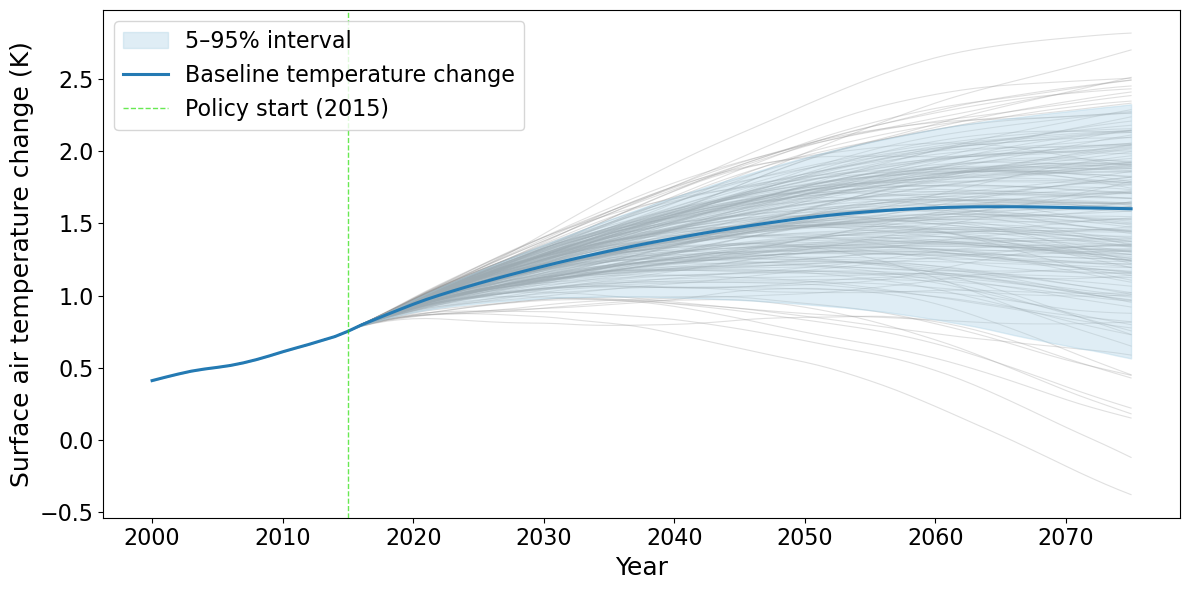

In [12]:
plot_temperature_ensemble(results, baseline_result, start_year=2000, n_sample=200, save_name="temperature_ensemble_new.pdf")

## 3. Plot the emission policies

In [79]:
import sys
import os
sys.path.insert(0,os.path.join(os.getcwd(), '../ciceroscm/', 'src'))

from ciceroscm import CICEROSCM
from ciceroscm.parallel.cscmparwrapper import run_ciceroscm_parallel
import ciceroscm.input_handler as input_handler

test_data_dir = "/home/obola/repositories/cicero-scm-surrogate/ciceroscm/tests/test-data"
em_data_start = 1900
em_data_policy = 2015
em_data_end = 2075

ih = input_handler.InputHandler({"nyend": em_data_end, "nystart": em_data_start, "emstart": em_data_policy})
em_data = ih.read_emissions(os.path.join(test_data_dir, "ssp245_em_RCMIP.txt"))

In [80]:
def plot_emission_ensemble(em_data, scenarios, gas, start_year=2000, n_sample=80, show_band=True, save_name=None):
    """
    Plot baseline trajectory (em_data[gas]) together with scenario trajectories.
    """
    mask = em_data.index >= start_year
    years = em_data.index[mask].to_numpy()
    baseline = em_data.loc[mask, gas].to_numpy()

    # Stack scenario series: shape T x S
    series = [scen["emissions_data"].loc[mask, gas].to_numpy() for scen in scenarios]
    M = np.stack(series, axis=1)

    # Percentiles for fan band
    if show_band:
        q5, q95 = np.percentile(M, [5, 95], axis=1)

    # Sample a subset for spaghetti
    S = M.shape[1]
    rng = np.random.default_rng(0)
    samp = np.arange(S) if S <= n_sample else rng.choice(S, size=n_sample, replace=False)

    # --- Plot ---
    plt.figure(figsize=(6, 3))
    # Scenario lines (light gray)
    plt.plot(years, M[:, samp], color="#999999", linewidth=0.8, alpha=0.15)
    # Percentile band (soft blue)
    if show_band:
        plt.fill_between(years, q5, q95, color="#a6cee3", alpha=0.35, label="5–95% interval")
    # Baseline (strong blue)
    plt.plot(years, baseline, color="#1f78b4", linewidth=2.2, label="Baseline")

    plt.xlabel("Year", fontsize = 14)
    plt.ylabel(f"{gas} emissions (Mt/yr)", fontsize = 14)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
   # plt.title(f"{gas} — Baseline and scenario ensemble")
    plt.legend(frameon=True, loc="upper right", bbox_to_anchor=(1, 1), fontsize = 12)    
    plt.tight_layout()

    if save_name:
        os.makedirs("plots", exist_ok=True)
        save_path = os.path.join("plots", save_name)
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

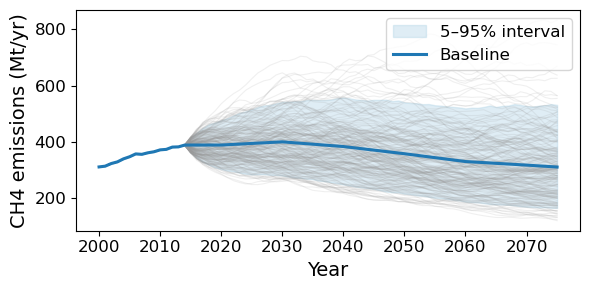

In [81]:
plot_emission_ensemble(em_data, scenarios, gas="CH4", n_sample=200, save_name="CH4_ensemble_new.pdf")

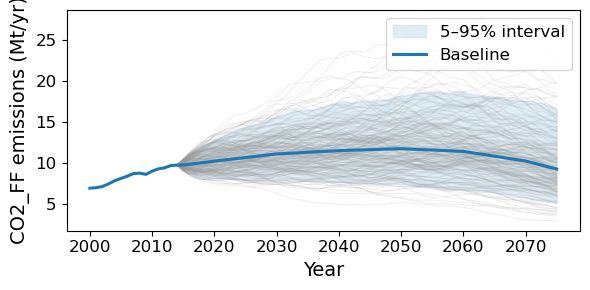

In [82]:
plot_emission_ensemble(em_data, scenarios, gas="CO2_FF", n_sample=200, save_name="CO2_FF_ensemble_new.pdf")

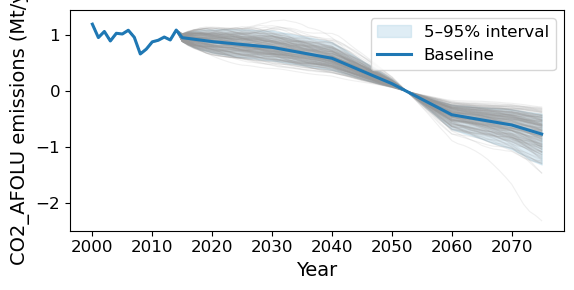

In [83]:
plot_emission_ensemble(em_data, scenarios, gas="CO2_AFOLU", n_sample=200, save_name="CO2_AFOLU_ensemble_new.pdf")

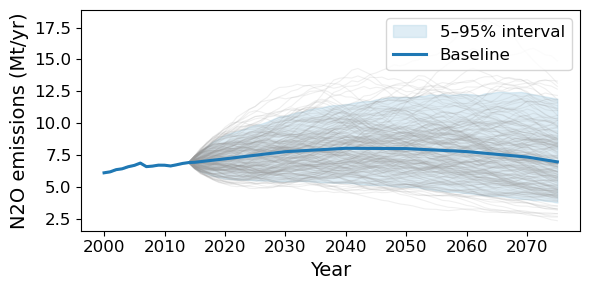

In [84]:
plot_emission_ensemble(em_data, scenarios, gas="N2O", n_sample=200, save_name="N2O_ensemble_new.pdf")

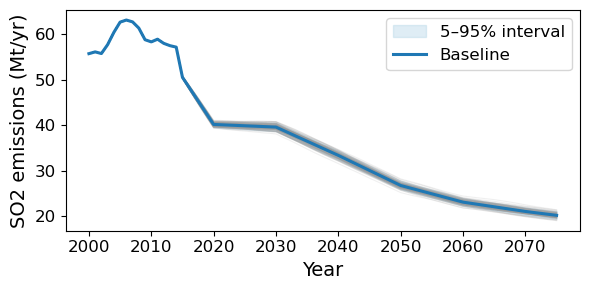

In [85]:
plot_emission_ensemble(em_data, scenarios, gas="SO2", n_sample=100, save_name="SO2_ensemble_new.pdf")

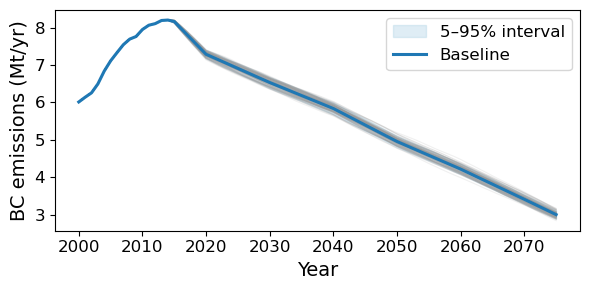

In [72]:
plot_emission_ensemble(em_data, scenarios, gas="BC",    n_sample=100, save_name="BC_ensemble_new.pdf")

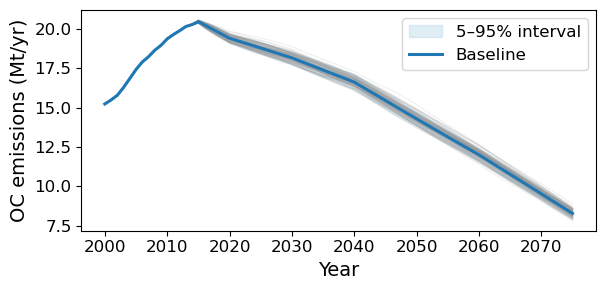

In [73]:
plot_emission_ensemble(em_data, scenarios, gas="OC",    n_sample=100, save_name="OC_ensemble_new.pdf")

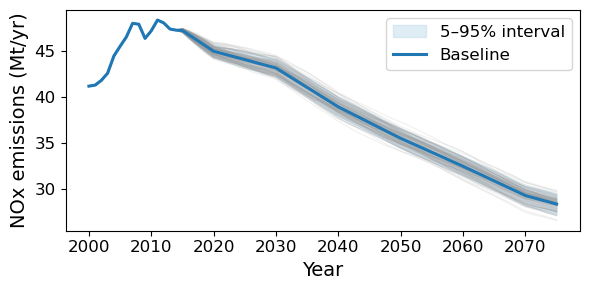

In [74]:
plot_emission_ensemble(em_data, scenarios, gas="NOx",   n_sample=100, save_name="NOx_ensemble_new.pdf")


## 4. Surrogate model training data format

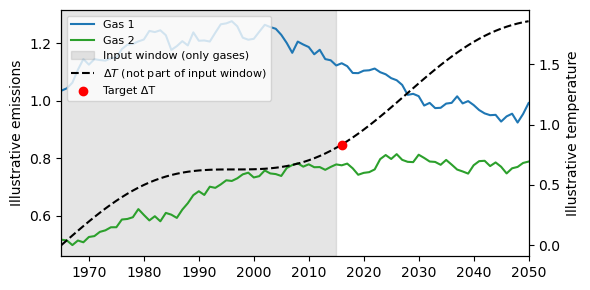

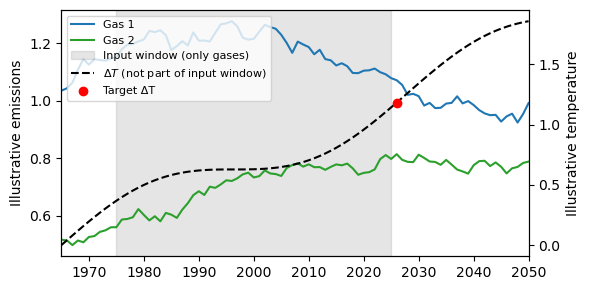

In [ ]:
# Function to plot schematic with clean style and updated legend
def plot_schematic(end_year, save_path):
    np.random.seed(0)
    years = np.arange(1965, 2051)
    n_years = len(years)
    
    # Simulated gas data
    gas1 = np.cumsum(np.random.randn(n_years)) * 0.02 + 1.0
    gas2 = np.cumsum(np.random.randn(n_years)) * 0.015 + 0.5
    temp = 0.02 * (years - 1965) + np.sin(0.1 * (years - 1965)) * 0.2  # base-like temperature
    
    start_window = end_year - 50
    mask_window = (years >= start_window) & (years <= end_year)
    
    fig, ax1 = plt.subplots(figsize=(6, 3))
    
    # Plot gases
    ax1.plot(years, gas1, label="Gas 1", color="tab:blue")
    ax1.plot(years, gas2, label="Gas 2", color="tab:green")
    
    # Highlight window
    ax1.axvspan(start_window, end_year, color="gray", alpha=0.2, label="Input window (only gases)")
    ax1.set_ylabel("Illustrative emissions")
    
    # Plot temperature on secondary axis
    ax2 = ax1.twinx()
    ax2.plot(years, temp, "--", color="black", label=r"$\Delta T$ (not part of input window)")
    ax2.set_ylabel("Illustrative temperature")
    
    # Mark target year
    target_year = end_year + 1
    target_temp = temp[years == target_year][0]
    ax2.scatter(target_year, target_temp, color="red", zorder=5, label="Target ΔT")
    
    # Legend combining both axes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left", fontsize=8)
    
    ax1.set_xlim(1965, 2050)
    plt.tight_layout()
    
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

# Save updated versions
plot_schematic(2015, "plots/schematic_window_2015.pdf")
plot_schematic(2025, "plots/schematic_window_2025.pdf")